In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os  
import glob
import pickle
import math
%matplotlib inline

In [2]:
################ Defining Undistort Function ################
f_file = open("cal_info.pkl", "rb")
cal_info = pickle.load(f_file)
f_file.close()
def undistort(img):
    mtx = cal_info["mtx"]
    dist = cal_info["dist"]
    un_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return un_img

In [3]:
################ Defining Binary Image ################
def binary_image(img, s_thresh=(140, 255), sx_thresh=(50, 255)):
    ########### Binary image for Color #################
    # Going to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    ########## Binary image for Gradiant ##############
    # Converting to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Getting x derivative
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # Getting absolute value
    abs_sobelx = np.absolute(sobelx)
    # Scaling and Converting to 8-bit
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Applying thresholds
    sx_binary = np.zeros_like(gray)
    sx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Defining the binary and binay_color
    binary = np.zeros_like(s_binary)
    binary[(s_binary == 1) | (sx_binary == 1)] = 1
    color_binary = np.dstack((s_binary, sx_binary, np.zeros_like(sx_binary)))*255
    
    return binary, color_binary

In [4]:
################ Defining Perspective Transform Function ################
# Loading the already indentified perspective info
f_file = open("perspective_info", "rb")
perspective_info = pickle.load(f_file)
f_file.close()
# Grabbing the M and Minv matrix
M = perspective_info["M"]
Minv = perspective_info["Minv"]

def warp(img, ptype=0):
    img_size = (img.shape[1], img.shape[0])
    if ptype == 0:
        un_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        un_img = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return un_img

In [5]:
################ Defining Histogram Function ################
def hist(img):
    # input for this function is the warped binary image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    # The output is a 1D array of img.shape[1] length
    return histogram

In [6]:
################ Defining the Function for Sliding Window ################
def slide_search(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [7]:
################ Defining the Function for Searching Around Polynomials ################
def poly_search(binary_warped, left_fit, right_fit):
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Visualization of the search area and margins
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return leftx, lefty, rightx, righty, result

In [8]:
def fit_polynomial(line):
    # Find line pixels using slide_search
    allx = line.allx
    ally = line.ally

    # Fit a second order polynomial to each using `np.polyfit`
    fit = np.polyfit(ally, allx, 2)
    
    # Generate x and y values for plotting
    ploty = line.ploty
    try:
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return fit, fitx

In [385]:
def visualize(warped, left, right):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    # For the shaded green safe area
    color_warp_1 = np.dstack((warp_zero, warp_zero, warp_zero))
    # For the line colors and the text
    color_warp_2 = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left.last_xfitted, left.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.last_xfitted, right.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp_1, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_1 = warp(color_warp_1, ptype=1)  
    
    # Coloring the line pixles
    color_warp_2[left.ally, left.allx] = left.color
    color_warp_2[right.ally, right.allx] = right.color
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_2 = warp(color_warp_2, ptype=1) 
    
    # Writing the radius on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius = (left.radius + right.radius)/2000
    # Avoiding ridiculously large radius values
    if radius > 5:
        str1 = "_"
    else:
        str1 = str(round(radius, 2))
    cv2.putText(newwarp_2,
                "Radius of Curvature = " + str1 + " km",
                (10,30),
                font,
                1,
                (255, 255, 255),
                2,
                cv2.LINE_AA)
    
    # Finding the vehicle distance w.r.t. center line
    xm_per_pix = 3.7/480 # meters per pixel in x dimension
    dist = (warped.shape[1]/2 - (right.last_xfitted[-1] + left.last_xfitted[-1])/2) * xm_per_pix
    cv2.putText(newwarp_2,
                "Distance from the lane center = " + str(round(dist, 2)) + " m",
                (10,60),
                font,
                1,
                (255, 255, 255),
                2,
                cv2.LINE_AA)

    return newwarp_1, newwarp_2

In [396]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # array of y values from 0 to img.shape[0]
        self.ploty = []
        # Number of last fits to hold
        self.n = 5
        # x values of the last fit of the line
        self.last_xfitted = [] 
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the last n recent fits
        self.recent_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Line color for visualization
        self.color = [255,0,0]
        # Line radius of curvature
        self.radius = None
    
    def x_append(self):
        if len(self.recent_xfitted) == self.n:
            self.recent_xfitted.pop(0)
            self.recent_xfitted.append(self.last_xfitted)
        else:
            self.recent_xfitted.append(self.last_xfitted)
    
    def fit_append(self):
        if len(self.recent_fit) == self.n:
            self.recent_fit.pop(0)
            self.recent_fit.append(self.current_fit)
        else:
            self.recent_fit.append(self.current_fit)
    
    def update(self):
        self.bestx = np.mean(np.array(self.recent_xfitted), axis=0)
        self.best_fit = np.mean(np.array(self.recent_fit), axis=0)
        if len(self.recent_fit) > 1:
            self.diffs = np.array(self.recent_fit[-1] - self.recent_fit[-2])
        # Calculating the radius of curvature
        y_eval = np.max(self.ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 40/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/480 # meters per pixel in x dimension
        if self.best_fit.any() != None:
            self.radius = (1 + (2*self.best_fit[0] * y_eval * (xm_per_pix/ym_per_pix) + self.best_fit[1] * (xm_per_pix/ym_per_pix))**2)**1.5/np.absolute(2*self.best_fit[0] * xm_per_pix / ym_per_pix**2) 

In [397]:
def fit_check(left_fit, left_fitx, right_fit, right_fitx):
    flag = True
    
    # Chekcing for the distance and being parallel
    if np.max(right_fitx - left_fitx) > 550 or np.min(right_fitx - left_fitx) < 400:
        flag = False
    
    # Checking for the curvature
    if (10**4 * np.absolute(right_fit[0] - left_fit[0]) + (right_fit[1] - left_fit[1])) > 10:
        flag = False
        
    return flag

In [398]:
Left = Line()
Right = Line()
Right.color = [0,0,255]
################ Defining the Pipeline ################
def pipeline(img_in):
    img = np.copy(img_in)
    un_img = undistort(img)
    binary_img, _ = binary_image(un_img)
    binary_warped = warp(binary_img)
    
    # Setting the ploty value of the lines
    Left.ploty = np.linspace(0, img.shape[0]-1, img.shape[0])  
    Right.ploty = np.linspace(0, img.shape[0]-1, img.shape[0])  
    
    if Left.detected and Right.detected:
        leftx, lefty, rightx, righty, out_img = poly_search(binary_warped, Left.current_fit, Right.current_fit)
        Left.allx = leftx
        Left.ally = lefty
        Right.allx = rightx
        Right.ally = righty
        left_fit, left_fitx = fit_polynomial(Left)
        right_fit, right_fitx = fit_polynomial(Right)
        if fit_check(left_fit, left_fitx, right_fit, right_fitx):
            # Appending the current fit values to the list of last n fit values
            Left.current_fit = left_fit
            Left.fit_append()
            Right.current_fit = right_fit
            Right.fit_append()
            # Appending the current x values to the list of last n x values
            Left.last_xfitted = left_fitx
            Left.x_append()
            Right.last_xfitted = right_fitx
            Right.x_append()
            # Updating the objects
            Left.update()
            Right.update()
        else:
            Left.detected = False
            Right.detected = False
    else:
        leftx, lefty, rightx, righty, out_img = slide_search(binary_warped)
        Left.detected = True
        Right.detected = True
        Left.allx = leftx
        Left.ally = lefty
        Right.allx = rightx
        Right.ally = righty
        left_fit, left_fitx = fit_polynomial(Left)
        right_fit, right_fitx = fit_polynomial(Right)
        if fit_check(left_fit, left_fitx, right_fit, right_fitx):
            # Appending the current fit values to the list of last n fit values
            Left.current_fit = left_fit
            Left.fit_append()
            Right.current_fit = right_fit
            Right.fit_append()
            # Appending the current x values to the list of last n x values
            Left.last_xfitted = left_fitx
            Left.x_append()
            Right.last_xfitted = right_fitx
            Right.x_append()
            # Updating the objects
            Left.update()
            Right.update()

    img_vis_1, img_vis_2 = visualize(binary_warped, Left, Right)
    out_img = cv2.addWeighted(img, 1, img_vis_1, 0.3, 0)
    out_img = cv2.addWeighted(out_img, 1, img_vis_2, 1, 0)
    
    return out_img

In [399]:
test_images = glob.glob("..\\test_images\\*.jpg")
img = mpimg.imread(test_images[1])   

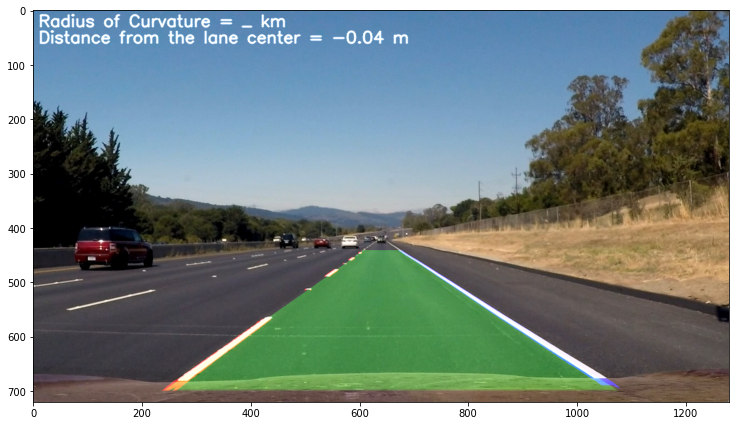

In [400]:
fig, ax = plt.subplots(figsize=(12.8,7.2))
plt.imshow(pipeline(img)) 

In [373]:
print(Right.last_xfitted[-1] - Left.last_xfitted[-1])

478.99222143188723


In [374]:
print(img.shape)

(720, 1280, 3)


In [391]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [392]:
test_videos = glob.glob("..\\*.mp4")
test_videos

['..\\challenge_video.mp4',
 '..\\harder_challenge_video.mp4',
 '..\\project_video.mp4']

In [393]:
clip1 = VideoFileClip(test_videos[2]).subclip(0,1)

In [394]:
out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
clip_output = "..\\test_videos_output\\clip_output.mp4"
%time out_clip.write_videofile(clip_output, audio=False)

t:   8%|█████▌                                                                | 2/25 [00:00<00:01, 13.93it/s, now=None]

Moviepy - Building video ..\test_videos_output\clip_output.mp4.
Moviepy - Writing video ..\test_videos_output\clip_output.mp4



Moviepy - Done !
Moviepy - video ready ..\test_videos_output\clip_output.mp4
Wall time: 3.12 s


In [395]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

In [382]:
Right.current_fit

array([-7.13785928e-04,  1.07140023e+00,  5.17908287e+02])

In [383]:
Left.current_fit

array([-7.28347799e-04,  1.07897533e+00,  3.56608887e+01])

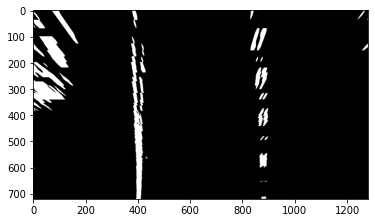

In [16]:
plt.imshow(binary_warped, cmap="gray")

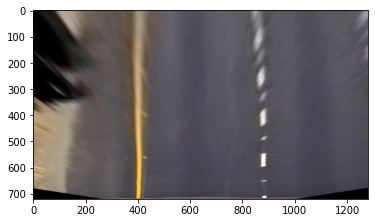

In [68]:
plt.imshow(warp(img))

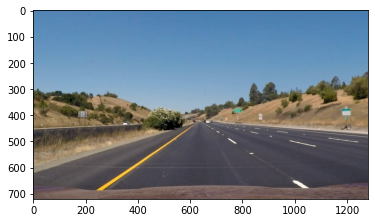

In [69]:
plt.imshow(img)